### **1. Imports and Initial Setup**



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from scipy import stats
import shap

### **2. Load Dataset**

In [ ]:
df = pd.read_csv('/content/tehranhouses.csv')
df[['Parking', 'Warehouse', 'Elevator']] = df[['Parking', 'Warehouse', 'Elevator']].astype(int)
df = df.dropna()
df = df.drop('Price', axis=1)
df['Price(USD)'] = df['Price(USD)'].astype(str).str.replace(',', '').astype(float)
df['Area'] = df['Area'].astype(str).str.replace(',', '').astype(float)

###**3.Address Statistical Importance Check**



In [ ]:
top_addresses = df['Address'].value_counts().nlargest(10).index
subset = df[df['Address'].isin(top_addresses)]

anova_result = stats.f_oneway(*[group['Price(USD)'].values for name, group in subset.groupby('Address')])
print(f"ANOVA F-statistic: {anova_result.statistic:.2f}")
print(f"p-value: {anova_result.pvalue:.6f}")


ANOVA F-statistic: 152.32
p-value: 0.000000


### **4. Feature Engineering** **bold text**

In [ ]:
df['PricePerSqm'] = df['Price(USD)'] / df['Area']
df.insert(2, 'PricePerSqm', df.pop('PricePerSqm'))
df['Address_encoded'] = df['Address'].astype('category').cat.codes

### **5. Visual Exploration**

**Display a sample of the dataset**

In [ ]:
print("Sample of Dataset:")
display(df.sample(5))

Sample of Dataset:


,Area,Room,PricePerSqm,Parking,Warehouse,Elevator,Address,Price(USD),Address_encoded
3248,58.0,1,729.885000,0,1,0,Azarbaijan,42333.33,19
2336,140.0,3,2214.285714,1,1,1,Farmanieh,310000.00,50
2557,120.0,2,450.000000,1,1,1,Majidieh,54000.00,91
3394,54.0,1,13888.888889,1,1,1,West Ferdows Boulevard,750000.00,183
120,120.0,3,1333.333333,1,1,1,Fatemi,160000.00,51


**Correlation heatmap**

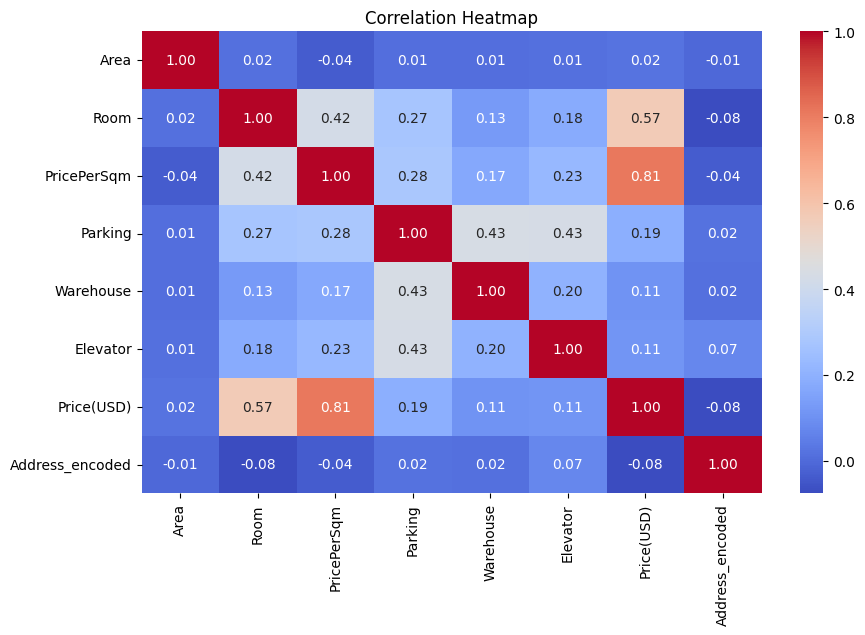

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


**Distribution plot of target variable**

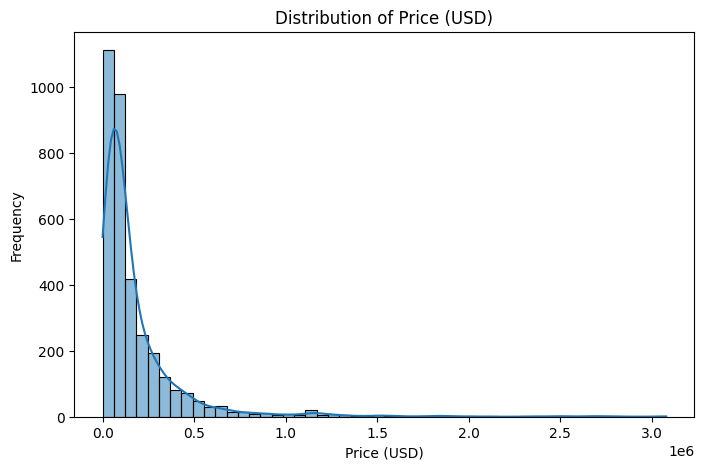

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Price(USD)'], bins=50, kde=True)
plt.title('Distribution of Price (USD)')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.show()

### **6. Prepare Features and Target** **bold text**

In [ ]:
y = df[['Price(USD)']]
X = df.drop('Price(USD)', axis=1)

### **7. Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### **8. Standardize Numerical Features**

In [ ]:
numerical_cols = ['Area', 'Room', 'PricePerSqm', 'Address_encoded']  # ستون‌های عددی‌ای که باید scale شوند

sc = StandardScaler()
X_train[numerical_cols] = sc.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = sc.transform(X_test[numerical_cols])

### **9. Train Initial CatBoost Model**

In [ ]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
model = CatBoostRegressor(verbose=0, random_state=0)
model.fit(X_train, y_train, cat_features=categorical_features)
y_pred = model.predict(X_test)

### **10. Hyperparameter Tuning with GridSearchCV**

In [ ]:
param_grid = {
'depth': [4, 6, 8],
'learning_rate': [0.03, 0.05],
'iterations': [500]
}
grid = GridSearchCV(estimator=CatBoostRegressor(verbose=0, random_state=0),
param_grid=param_grid,
cv=3,
scoring='neg_mean_absolute_error',
n_jobs=-1)
grid.fit(X_train, y_train, cat_features=categorical_features)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

### **11. Evaluation Metrics**

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test.values.flatten() - y_pred) / y_test.values.flatten())) * 100

print(f"Best Params: {grid.best_params_}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

Best Params: {'depth': 6, 'iterations': 500, 'learning_rate': 0.05}
MAE: 7824.87
R²: 0.9827
MAPE: 4.53%


### **12. Feature Importance Visualization with SHAP**

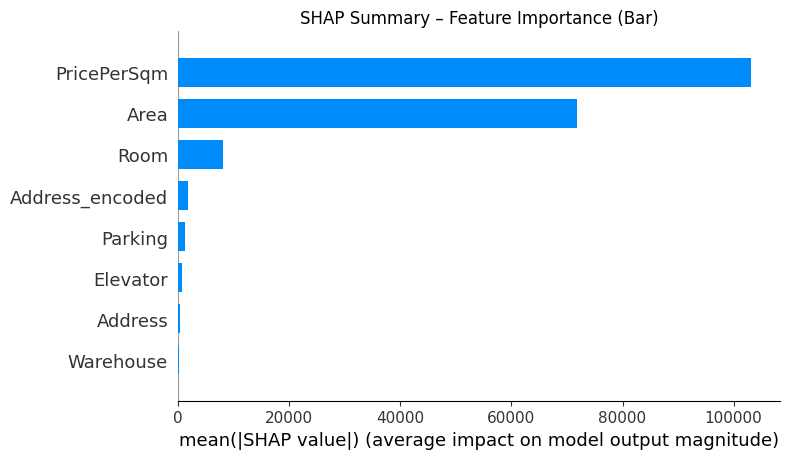

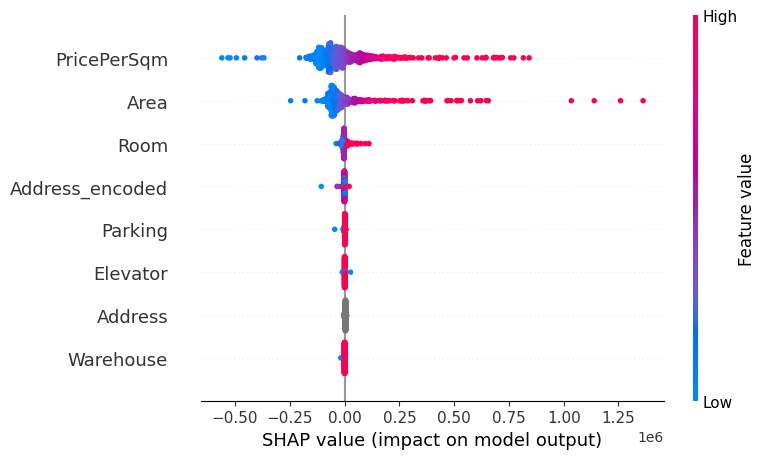

In [60]:
 explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
plt.title("SHAP Summary – Feature Importance (Bar)")
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)